In [1]:
import numpy as np
import pylab as plt
import scipy.stats as ss
import os
import sys
import pickle
sys.path.append(os.path.abspath(os.path.join('../..')))
import pyabc
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

warning in stationary: failed to import cython module: falling back to numpy


/home/michael/anaconda3/envs/elfi/lib/python3.5/site-packages/GPyOpt/__init__.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/michael/anaconda3/envs/elfi/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/michael/anaconda3/envs/elfi/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/michael/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/michael/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/michael/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py

# The problem

We begin with a very intuitive and easy toy example that will allow us to analytically compute the posterior. Our model will be $x \sim \mathcal{N}(\mu,\sigma^2)$, that is $x$ is distributed according to a Gaussian normal distribution with mean $\mu$ and variance $\sigma^2$. Let us assume that we have observed data $D=\{x_i|i=1,\ldots,30\}$ for which we know the variance $\sigma^2$ (for example from previous experiments or from literature), but we will assume that the data was measured with noise, so $\sigma^2=\sigma^2_0 + \sigma^2_n$. We are first interested in the mean $\mu$ of the generative model and afterwards in the variance $\sigma^2$, so we fix one of the parameters while we infer the other.

# Generative Model

For the purpose of different priors, we assume that our generative model has the following shape: $g: \mathcal{N}(0.5, 0.5)$

In [2]:
mu_t = 0.5
sigma_t = 0.5
noise = 0
N = 20

if os.path.exists(os.path.join("data", "D.pkl")):
    D = pickle.load(open(os.path.join("data", "D.pkl"), "rb"))
else:
    D = np.random.normal(mu_t, np.sqrt(sigma_t + noise), N)
    os.makedirs(os.path.basename(os.path.join("data", "D")), exist_ok=True)
    pickle.dump(D, open(os.path.join("data", "D.pkl"), "wb"))


<IPython.core.display.Javascript object>


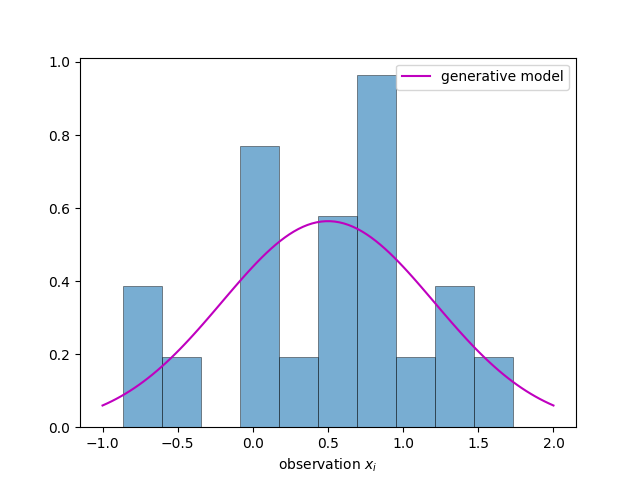

Text(0.5,0,'observation $x_i$')

In [3]:
plt.figure()
plt.hist(D, edgecolor="k", linewidth=0.5, color=["C0"], normed=True, alpha=0.6, histtype="bar")
x = np.linspace(-1, 2, 100)
y = ss.norm.pdf(x, mu_t, np.sqrt(sigma_t))
plt.plot(x,y, "-", color="m", label="generative model")
plt.legend()
plt.xlabel("observation $x_i$")

# Prior and Likelihood

We are interested in the probability distribution of the model parameter $\theta=\mu$ given our observed data, thus with Bayes' Theorem we can write

$p(\theta|D) \propto p(D|\theta) \cdot p(\theta).$

With the assumption of indentically and independently distributed (i.i.d.) drawn samples, the likelihood $p(D|\theta)$ can be written as the product of the likelihoods for each datum: $p(D|\theta) = \prod_{i=1}^N p(x_i|\theta) = \prod_{i=1}^N \mathcal{N}(x_i|\mu, \sigma^2)$.

The prior represents our initial belief about the values $\theta=\mu$ might take. We will analyse the following three priors that represent very different initial belief sets.

$p_1(\theta) = Uniform(0, 1)$

$p_2(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0)$, with $\mu_0 = 0, \sigma_0 = 1$

For the last prior, we switch our $\theta$ to become $\sigma^2$, that is we are now interested in the variance of our data and we assume that we now the mean $\mu$. 

$p_3(\theta=\lambda) = Gamma(2, 1/3)$ (loc=2)

<IPython.core.display.Javascript object>


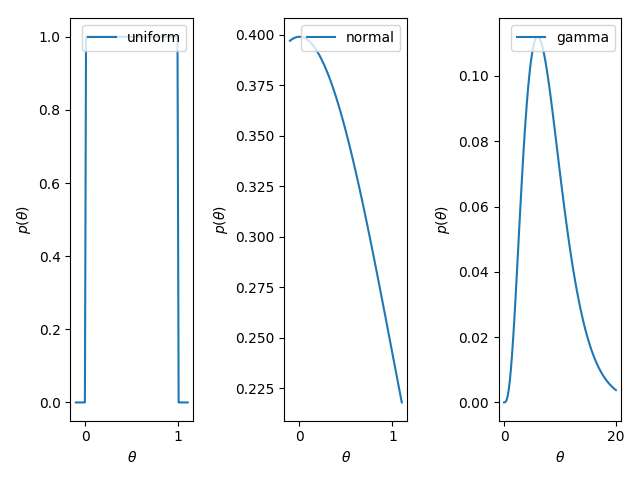

In [4]:
plt.figure()

# uniform prior
plt.subplot(1,3,1)
x = np.linspace(-0.1, 1.1, 100)
y = ss.uniform.pdf(x, 0, 1)
plt.plot(x,y, label="uniform")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# normal distributed prior
plt.subplot(1,3,2)
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, 0, 1)
plt.plot(x,y, label="normal")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# gamma distributed prior
plt.subplot(1,3,3)
x = np.linspace(0, 20, 100)
y = ss.gamma.pdf(x, a=4, scale=2, loc=0)
plt.plot(x,y, label="gamma")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.tight_layout()

# Posterior

Now we look at the posterior. For each of the three priors, we can analytically calculate the posterior. Lets do this:

$\begin{align}
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_1(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot 1 = \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \mu, \sigma^2_N = \cfrac{1}{N}\sigma^2 \\
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot \mathcal{N}(\mu_0, \sigma^2_0) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \cfrac{1}{N\sigma_0^2 + \sigma^2} \cdot (\sigma^2\mu_0 + N\sigma_0^2\mu), \sigma^2_N = \cfrac{\sigma^2\sigma^2_0}{N\sigma^2_0 + \sigma^2} \\
p(\theta = \lambda = \frac{1}{\sigma^2}|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot Gamma(2, 2) = Gamma(a_N, b_N), a_N = a + \cfrac{N}{2}, b_N = b + \cfrac{1}{2}\sum_{i=1}^N (x_i - \mu)^2
\end{align}$

In [5]:
mu_t, sigma_t = 0.5, 0.5
mu_0, sigma_0 = 0, 1
a0, b0 = 4, 1/2
N = 20

posterior1 = lambda x,N: ss.norm.pdf(x, mu_t, np.sqrt(1/N * sigma_t))
posterior2 = lambda x,N: ss.norm.pdf(x, 1 / (N * sigma_0 + sigma_t) * (sigma_t * mu_0 + N * sigma_0 * mu_t), np.sqrt((sigma_t * sigma_0) / (N * sigma_0 + sigma_t)))
posterior3 = lambda x,N: ss.gamma.pdf(x, a=(a0 + N/2), scale = 1/(b0 + 0.5 * N * sigma_t))

<IPython.core.display.Javascript object>


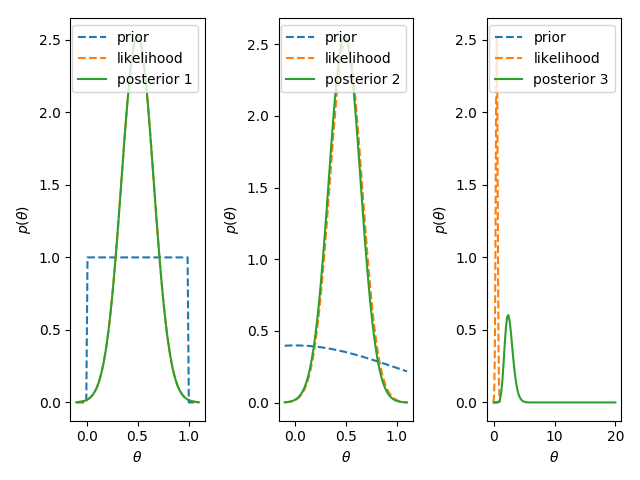

In [6]:
plt.figure()

# uniform prior
plt.subplot(1,3,1)
x = np.linspace(-0.1, 1.1, 100)
y = ss.uniform.pdf(x, 0, 1)
plt.plot(x,y, "--", label="prior")

x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_t, np.sqrt(1/N * sigma_t))
plt.plot(x,y, "--", label="likelihood")

x = np.linspace(-0.1, 1.1, 100)
y = posterior1(x, N)
plt.plot(x,y, label="posterior 1")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.subplot(1,3,2)
# normal distributed prior
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_0, np.sqrt(sigma_0))
plt.plot(x,y, "--", label="prior")

y = ss.norm.pdf(x, mu_t, np.sqrt(1/N * sigma_t))
plt.plot(x,y, "--", label="likelihood")

y = posterior2(x, N)
plt.plot(x,y, label="posterior 2")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.subplot(1,3,3)
# gamma distributed prior
x = np.linspace(-0.1, 1.1, 100)
y = ss.gamma.pdf(x, a=a0, scale=1/b0, loc=0)
plt.plot(x,y, "--", label="prior")


y = ss.norm.pdf(x, mu_t, np.sqrt(1/N * sigma_t))
plt.plot(x,y, "--", label="likelihood")

x = np.linspace(0, 20, 100)
y = posterior3(x, N)
plt.plot(x,y, label="posterior 3")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.tight_layout()

# ABC

In [7]:
mu_t, sigma_t = 0.5, 0.5
mu_0, sigma_0 = 0, 1
a0, b0 = 4, 1/2
loc = 0
N = 20

prior1 = pyabc.Prior("uniform", 0, 1, name="mu")
prior2 = pyabc.Prior("normal", mu_0, np.sqrt(sigma_0), name="mu")
prior3 = pyabc.Prior("gamma", a0, loc, 1/b0, name="lambda")

In [8]:
def simulator_mu(mu):
    return ss.norm(loc=mu, scale=np.sqrt(sigma_t)).rvs(N)

def simulator_lambda(_lambda):
    return ss.norm(loc=mu_t, scale=np.sqrt(1/_lambda)).rvs(N)

In [9]:
def mean(x):
    return np.mean(x)

def var(x):
    return np.var(x)

<IPython.core.display.Javascript object>


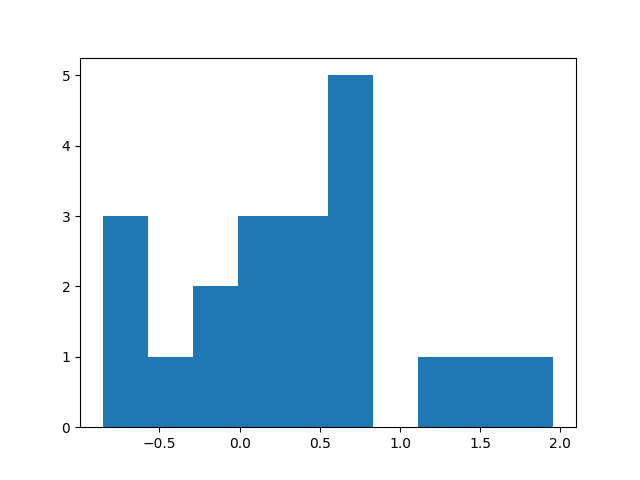

(array([ 3.,  1.,  2.,  3.,  3.,  5.,  0.,  1.,  1.,  1.]),
 array([-0.85493692, -0.57369773, -0.29245854, -0.01121936,  0.27001983,
         0.55125902,  0.8324982 ,  1.11373739,  1.39497657,  1.67621576,
         1.95745495]),
 <a list of 10 Patch objects>)

In [10]:
plt.figure()
plt.hist(simulator_mu(0.5))

<IPython.core.display.Javascript object>


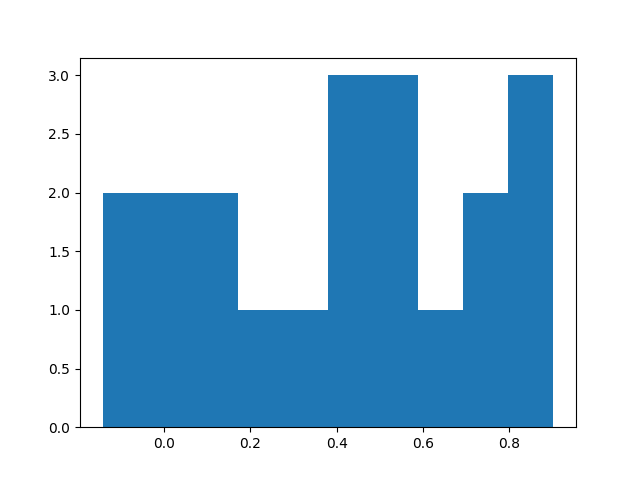

(array([ 2.,  2.,  2.,  1.,  1.,  3.,  3.,  1.,  2.,  3.]),
 array([-0.14260789, -0.03816078,  0.06628633,  0.17073344,  0.27518055,
         0.37962765,  0.48407476,  0.58852187,  0.69296898,  0.79741609,
         0.9018632 ]),
 <a list of 10 Patch objects>)

In [11]:
plt.figure()
plt.hist(simulator_lambda(10))

## Prior 1

In [12]:
rej = pyabc.RejectionSampler(priors=prior1, simulator=simulator_mu, summaries=[mean, var], observation=D)

<IPython.core.display.Javascript object>


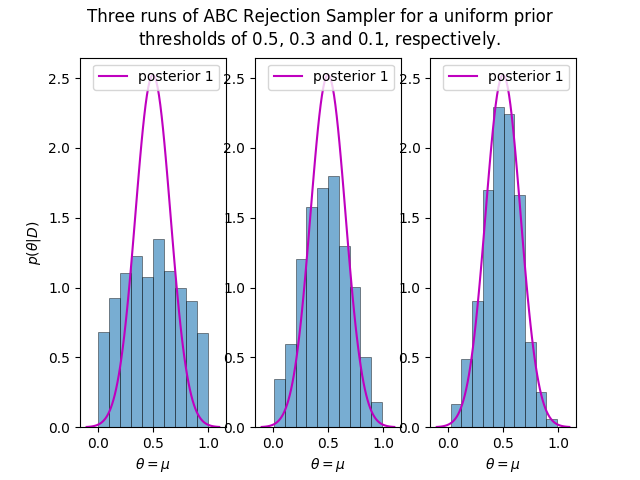

Rejection sampler started with threshold: 0.5 and number of samples: 1000
Samples:   1000 - Threshold: 0.5000 - Iterations:       2000 - Acceptance rate: 0.500000 - Time:     1.46 s
Rejection sampler started with threshold: 0.3 and number of samples: 1000
Samples:   1000 - Threshold: 0.3000 - Iterations:       3000 - Acceptance rate: 0.333333 - Time:     2.06 s
Rejection sampler started with threshold: 0.1 and number of samples: 1000
Samples:   1000 - Threshold: 0.1000 - Iterations:      13000 - Acceptance rate: 0.076923 - Time:     8.98 s


Text(0.5,0.98,'Three runs of ABC Rejection Sampler for a uniform prior\nthresholds of $0.5$, $0.3$ and $0.1$, respectively.')

In [13]:
N = 20
scale = 1
x = np.linspace(-0.1, 1.1, 100)
y = posterior1(x, N) * scale

iterations = []
acceptance_rates = []
runtimes = []

fig = plt.figure()

rej.sample(nr_samples=1000, threshold=0.5)
iterations.append(rej.nr_iter)
acceptance_rates.append(rej.acceptance_rate)
runtimes.append(rej.runtime)

plt.subplot(1,3,1)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")


rej.sample(nr_samples=1000, threshold=0.3)
iterations.append(rej.nr_iter)
acceptance_rates.append(rej.acceptance_rate)
runtimes.append(rej.runtime)
rej.save(os.path.join("data", "rej_prior1_1000_03.pkl"))

plt.subplot(1,3,2)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")


rej.sample(nr_samples=1000, threshold=0.1)
iterations.append(rej.nr_iter)
acceptance_rates.append(rej.acceptance_rate)
runtimes.append(rej.runtime)

plt.subplot(1,3,3)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")
plt.xlabel(r"$\theta=\mu$")


fig.suptitle("Three runs of ABC Rejection Sampler for a uniform prior\nthresholds of $0.5$, $0.3$ and $0.1$, respectively.")

In [15]:
rej = pyabc.RejectionSampler.load(os.path.join("data", "rej_prior1_1000_03.pkl"))
rej.Thetas

array([[ 0.49396296],
       [ 0.67285512],
       [ 0.22052047],
       [ 0.50785828],
       [ 0.10911848],
       [ 0.87103395],
       [ 0.36755416],
       [ 0.26249187],
       [ 0.46691377],
       [ 0.67984716],
       [ 0.49279189],
       [ 0.01396091],
       [ 0.105799  ],
       [ 0.87834326],
       [ 0.24132604],
       [ 0.38630407],
       [ 0.74152769],
       [ 0.78618785],
       [ 0.68015197],
       [ 0.35802849],
       [ 0.50788285],
       [ 0.78161424],
       [ 0.18825356],
       [ 0.46714313],
       [ 0.52814377],
       [ 0.06142653],
       [ 0.6638133 ],
       [ 0.55973731],
       [ 0.63450138],
       [ 0.23399157],
       [ 0.56758412],
       [ 0.57835462],
       [ 0.55391756],
       [ 0.41852582],
       [ 0.60549441],
       [ 0.63490255],
       [ 0.51317748],
       [ 0.50424604],
       [ 0.39964481],
       [ 0.33967418],
       [ 0.47475189],
       [ 0.22605596],
       [ 0.65835866],
       [ 0.44468689],
       [ 0.3226251 ],
       [ 0

In [14]:
rej.sample(nr_samples=10000, threshold=0.05)
rej.save(os.path.join("data", "rej_prior1_10000_005.pkl"))

Rejection sampler started with threshold: 0.05 and number of samples: 10000
Samples:  10000 - Threshold: 0.0500 - Iterations:     481000 - Acceptance rate: 0.020790 - Time:   365.88 s


PicklingError: Can't pickle <function BaseSampler.<lambda> at 0x7fb2c4548ae8>: attribute lookup BaseSampler.<lambda> on pyabc.sampler failed

In [ ]:
# look at runtime, instances, acceptance rate
plt.figure()

plt.subplot(1,3,1)

plt.bar(range(1,4), iterations, alpha=0.6, edgecolor="k", linewidth=0.5)
plt.xlabel("threshold")
plt.xticks(range(1,4), [0.5, 0.3, 0.1])
plt.title("number of iterations")

plt.subplot(1,3,2)

plt.bar(range(1,4), acceptance_rates, alpha=0.6, edgecolor="k", linewidth=0.5)
plt.xlabel("threshold")
plt.xticks(range(1,4), [0.5, 0.3, 0.1])
plt.title("acceptance rates")

plt.subplot(1,3,3)

plt.bar(range(1,4), runtimes, alpha=0.6, edgecolor="k", linewidth=0.5)
plt.xlabel("threshold")
plt.xticks(range(1,4), [0.5, 0.3, 0.1])
plt.title("runtimes")

In [ ]:
# how thetas and distances are correlated
plt.figure()
plt.scatter(rej.Thetas, rej.distances)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho(S(X),S(Y))$")

plt.figure()
plt.hist(rej.distances, alpha=0.6, linewidth=0.5, edgecolor="k")
plt.xlabel(r"$\rho(S(X),S(Y))$")

In [ ]:
# most exact?
mcmc = pyabc.MCMCSampler(priors=prior1, simulator=simulator_mu, summaries=[mean, var], observation=D)
mcmc.sample(nr_samples=1000, threshold=0.02, step_size=[0.01])

In [ ]:
N = 20
scale = 1
x = np.linspace(-0.1, 1.1, 100)
y = posterior1(x, N) * scale

fig = plt.figure()

plt.hist(mcmc.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x, y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")

fig.suptitle("One run of ABC MCMC Sampler for a uniform prior\n$N=1000$, threshold = $0.03$.")

In [ ]:
# how thetas and distances are correlated
plt.figure()
plt.scatter(mcmc.Thetas, mcmc.distances)

plt.figure()
plt.hist(mcmc.distances, alpha=0.6, linewidth=0.5, edgecolor="k")

In [ ]:
smc = pyabc.SMCSampler(priors=prior1, simulator=simulator_mu, summaries=[mean, var], observation=D)
smc.sample(nr_samples=1000, thresholds=[0.5, 0.3, 0.1, 0.05])

In [ ]:
N = 20
scale = 1
x = np.linspace(-0.1, 1.1, 100)
y = posterior1(x, N) * scale

fig = plt.figure()

plt.hist(smc.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x, y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")

fig.suptitle("One run of ABC SMC Sampler for a uniform prior\n$N=1000$, threshold = $0.01$.")

In [ ]:
# how thetas and distances are correlated
plt.figure()
plt.scatter(smc.Thetas, smc.distances[-1])

plt.figure()
plt.hist(smc.distances[-1], alpha=0.6, linewidth=0.5, edgecolor="k")

# Prior 2

In [ ]:
rej = pyabc.RejectionSampler(priors=prior2, simulator=simulator_mu, summaries=[mean, var], observation=D)

In [ ]:
fig = plt.figure()
N = 20
scale = 1
x = np.linspace(-0.1, 1.1, 100)
y = posterior2(x, N) * scale

rej.sample(nr_samples=1000, threshold=0.5)

plt.subplot(1,3,1)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 2")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")


rej.sample(nr_samples=1000, threshold=0.3)

plt.subplot(1,3,2)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 2")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")



rej.sample(nr_samples=1000, threshold=0.1)

plt.subplot(1,3,3)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 2")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")

fig.suptitle("Three runs of ABC Rejection Sampler for a normal prior\nthresholds of $0.5$, $0.3$ and $0.1$, respectively.")

In [ ]:
# most exact?
mcmc = pyabc.MCMCSampler(priors=prior2, simulator=simulator_mu, summaries=[mean, var], observation=D)
mcmc.sample(nr_samples=1000, threshold=0.02, step_size=[0.01])

In [ ]:
N = 20
scale = 1
x = np.linspace(-0.1, 1.1, 100)
y = posterior2(x, N) * scale

fig = plt.figure()

plt.hist(mcmc.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x, y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")

fig.suptitle("One run of ABC MCMC Sampler for a normal prior\n$N=1000$, threshold = $0.03$.")

In [ ]:
plt.figure()

plt.scatter(mcmc.Thetas, mcmc.distances)

plt.figure()
plt.hist(mcmc.distances, alpha=0.6, edgecolor="k", linewidth=0.5)

## Prior 3

In [ ]:
rej = pyabc.RejectionSampler(priors=prior3, simulator=simulator_lambda, summaries=[mean, var], observation=D)

In [ ]:
fig = plt.figure()
N = 20
scale = 1
x = np.linspace(0, 20, 100)
y = posterior3(x, N) * scale

rej.sample(nr_samples=1000, threshold=0.5)

plt.subplot(1,3,1)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 3")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")


rej.sample(nr_samples=1000, threshold=0.3)

plt.subplot(1,3,2)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 3")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")



rej.sample(nr_samples=1000, threshold=0.1)

plt.subplot(1,3,3)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior 3")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")

fig.suptitle("Three runs of ABC Rejection Sampler for a gamma prior\nthresholds of $0.5$, $0.3$ and $0.1$, respectively.")

# Example of different prior locations

We examine again the case of a conjugate normal prior

$\begin{align}
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot \mathcal{N}(\mu_0, \sigma^2_0) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \cfrac{1}{N\sigma_0^2 + \sigma^2} \cdot (\sigma^2\mu_0 + N\sigma_0^2\mu), \sigma^2_N = \cfrac{\sigma^2\sigma^2_0}{N\sigma^2_0 + \sigma^2} \\
\end{align}$

But this time we analyse three different priors with respect to their mean localtion $\mu_0$

$p_1(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0^2)$, with $\mu_0 = -1, \sigma_0^2 = 0.2$

$p_2(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0^2)$, with $\mu_0 = 0.5, \sigma_0^2 = 1$

$p_3(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0^2)$, with $\mu_0 = 2, \sigma_0^2= 0.2$

In [ ]:
plt.figure()
N = 20

x = np.linspace(-2, 3, 100)
likelihood = ss.norm.pdf(x, mu_t, np.sqrt(1/N * sigma_t))
posterior = lambda x, mu_0, sigma_0, N: ss.norm.pdf(x, 1 / (N * sigma_0 + sigma_t) * (sigma_t * mu_0 + N * sigma_0 * mu_t), np.sqrt((sigma_t * sigma_0) / (N * sigma_0 + sigma_t)))

# normal prior
plt.subplot(1,3,1)
mu_0, sigma_0 = -1, 0.1

y = ss.norm.pdf(x, mu_0, sigma_0)
plt.plot(x, y, label="prior 1")
plt.plot(x, likelihood, label="likelihood")
plt.plot(x, posterior(x, mu_0, sigma_0, N), label="posterior")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$|$p(D|\theta)$|$p(\theta|D)$")
plt.legend(loc="upper right")

# normal distributed prior
plt.subplot(1,3,2)
mu_0, sigma_0 = 0.5, 1

y = ss.norm.pdf(x, mu_0, sigma_0)
plt.plot(x, y, label="prior 2")
plt.plot(x, likelihood, label="likelihood")
plt.plot(x, posterior(x, mu_0, sigma_0, N), label="posterior")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# normal distributed prior
plt.subplot(1,3,3)
mu_0, sigma_0 = 2, 0.1

y = ss.norm.pdf(x, mu_0, sigma_0)
plt.plot(x, y, label="prior 3")
plt.plot(x, likelihood, label="likelihood")
plt.plot(x, posterior(x, mu_0, sigma_0, N), label="posterior")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.tight_layout()

In [ ]:
mu_t, sigma_t = 0.5, 0.3
N = 20

prior1 = pyabc.Prior("normal", -1, .1, name="mu")
prior2 = pyabc.Prior("normal", 0, 1, name="mu")
prior3 = pyabc.Prior("normal", 2, .1, name="mu")

In [ ]:
smc = pyabc.SMCSampler(priors=prior1, simulator=simulator_mu, summaries=[mean, var], observation=D)

In [ ]:
smc.sample(nr_samples=1000, thresholds=[2, 1.5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]) # rej rechnet sich zu tode # very sensitive for right choice of start values!!

In [ ]:
fig = plt.figure()
N = 20
scale = 1
x = np.linspace(-2, 2, 100)

mu_0, sigma_0 = -1, 0.1
y = posterior(x, mu_0, sigma_0, N) * scale
plt.hist(smc.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
plt.plot(x,y, "m-", label="posterior")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")